In [1]:
import torch
import clip
from PIL import Image
import pandas as pd
df = pd.read_parquet("/mnt/datasets/multimodal/laion/part0.snappy.parquet")


/opt/conda/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import ipyplot
N=10
small = df.sample(n=N)
images_array=small["URL"].iloc[0:N].values
texts_array=small["TEXT"].iloc[0:N].values
print("one sample:",small.iloc[0])
#ipyplot.plot_images(images_array, texts_array, max_images=N, img_width=200)

one sample: SAMPLE_ID                                       3965892006396.0
URL           https://i.pinimg.com/236x/89/78/fa/8978fa7933c...
TEXT          Forest Pond House, conceived as a meditation r...
HEIGHT                                                    236.0
WIDTH                                                     322.0
LICENSE                                                       ?
NSFW                                                   UNLIKELY
similarity                                              0.30344
Name: 7820207, dtype: object


In [3]:
import requests
import numpy as np
from io import BytesIO
def download_img(url,pth,filename):
    #code from open_clip/src/data/gather_cc.py
    try:
        dat = requests.get(url, timeout=20)
        if dat.status_code != 200:
            print("404 file", url)
            return

        # Try to parse this as an Image file, we'll fail out if not
        im = Image.open(BytesIO(dat.content))
        # im.thumbnail((512, 512), PIL.Image.BICUBIC)
        # if min(*im.size) < max(*im.size)/3:
        #     print("Too small", url)
        #     return
        im_pth = pth+"/%s.jpg"%(filename)

        im.save(im_pth)

        # Another try/catch just because sometimes saving and re-loading
        # the image is different than loading it once.
        try:
            o = Image.open(im_pth)
            o = np.array(o)

            print("Success", o.shape, filename)
            return im_pth
        except:
            print("Failed", filename)            
    except Exception as e:
        print("Unknown error", e)
        pass
img_pths=[]
texts=[]
for i,url in enumerate(images_array):
    img_pth=download_img(url,"/data/data_sample/laion",str(i))
    if not img_pth:
        continue
    else:
        img_pths.append(img_pth)
        texts.append(texts_array[i])


Unknown error HTTPSConnectionPool(host='i.pinimg.com', port=443): Max retries exceeded with url: /236x/89/78/fa/8978fa7933cd99e9a1384aca24b15883.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f3423ef8d30>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
Success (310, 194, 3) 1
Success (320, 320, 3) 2
Unknown error cannot write mode P as JPEG
Success (101, 180, 3) 4
Success (512, 512, 3) 5
404 file http://www.howitworksdaily.com/wp-content/uploads/2014/07/Credit-Bundesarchiv_Bild_102-11928_Ozeanflieger_Wiley_Post_und_Harold_Gatty-616x431.jpg
Success (270, 340, 3) 7
404 file http://i00.i.aliimg.com/wsphoto/v0/511763972/free-shipping-japan-anime-pokemon-pikachu-pvc-figure-set-b1056.jpg_120x120.jpg
Success (160, 240, 3) 9


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device,download_root="/mnt/clip_models/ViT-B-32")

In [11]:
import time
for i,pth in enumerate(img_pths):
    if i==0:
        t0=time.time()
        images=preprocess(Image.open(pth)).unsqueeze(0).to(device)
        print("transform a image time:",time.time()-t0)
        continue
    else:
        images = torch.cat((images,preprocess(Image.open(pth)).unsqueeze(0).to(device)),0)    

text_inputs = clip.tokenize(texts,truncate=True).to(device)    
start=time.time()
with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text_inputs)
    imf = image_features.unsqueeze(1)
    tf = text_features.unsqueeze(0)
    sim = torch.cosine_similarity(image_features,text_features).cpu().numpy()
    simMatrix = torch.cosine_similarity(imf,tf,dim=-1).cpu().numpy()
end=time.time()
print("similarity:",sim,"model inference times:{:.3f}s".format(end-start)) 
print("similarity Matrix:\n",simMatrix)
room=torch.cuda.max_memory_allocated(device)/(1024*1024)#MB
print("cuda memory usage:{:.2f}MB".format(room))

transform a image time: 0.02871227264404297
similarity: [0.3271 0.3025 0.3342 0.349  0.3516 0.3079] model inference times:0.018s
similarity Matrix:
 [[0.3271  0.0647  0.1277  0.1893  0.04218 0.135  ]
 [0.1635  0.3025  0.12103 0.1613  0.07544 0.1145 ]
 [0.2676  0.0501  0.3342  0.2593  0.02104 0.1191 ]
 [0.2354  0.0754  0.2637  0.349   0.02612 0.1163 ]
 [0.1538  0.1078  0.08203 0.1213  0.3516  0.1573 ]
 [0.1732  0.07874 0.1175  0.1448  0.02156 0.3079 ]]
cuda memory usage:355.74MB


similarity Matrix: 第i行j列代表第i个图片与第j个文本的相似度

similarity mean: 0.3286 standard deviation: 0.01868
Angry Busters - screenshot thumbnail
similarity: 0.2676


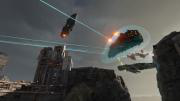

Dreadnought: Screen zur Weltraumaction.
similarity: 0.3342


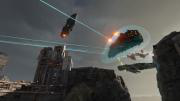

Assault Squadron icon
similarity: 0.2593


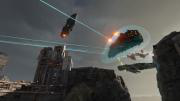

Dreadnought: Screen zur Weltraumaction.
similarity: 0.2637


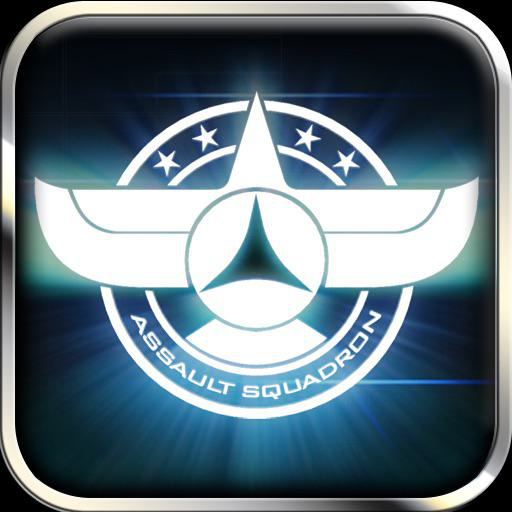

Angry Busters - screenshot thumbnail
similarity: 0.3271


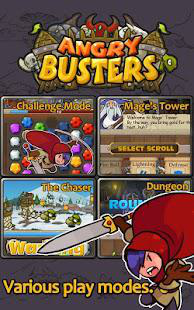

max similarity:
Illinois Watercolor Map Greeting Card, Welcome to Illinois Hand Lettered Text, Gift or Postcard, Giclée Print, Map Art, Choice of 5 Colors
similarity: 0.3516


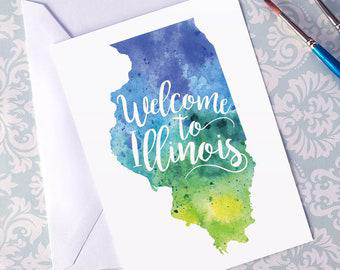

min similarity:
1960s Vintage Design Institute of America High Back Chrome & Velvet Pinstripe Dining Chairs- Set of 6 For Sale
similarity: 0.3025


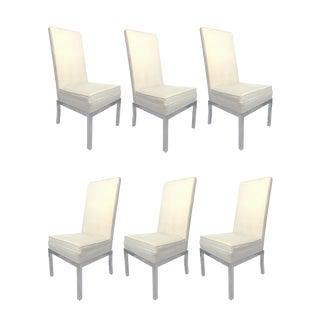

In [12]:
import numpy as np
def show(id):
    print(texts[id])
    print("similarity:",sim[id])
    Image.open(img_pths[id]).show()
def showij(im_id,t_id):
    print(texts[t_id])
    print("similarity:",simMatrix[im_id,t_id])
    Image.open(img_pths[im_id]).show()
print("similarity mean:",np.mean(sim),"standard deviation:",np.std(sim))
L=[[2,0],[2,2],[2,3],[3,2]]
for l in L:
    showij(l[0],l[1])
show(0)
print("max similarity:")
idh=np.argmax(sim)
show(idh)
print("min similarity:")
idl=np.argmin(sim)
show(idl)
# for i in range(3):
#     show(i)

# fig=plt.figure(figsize=(3,15))
# cols=2
# n=len(img_pths)
# rows=math.ceil(n/cols)
# for i in range(n):
#     fig.add_subplot(rows,cols,i+1)
#     plt.imshow(Image.open(img_pths[i]))
#     plt.title(texts[i]+"\nsimilarity:"+str(sim[i]), wrap=True)
#     plt.axis("off")
# plt.show()

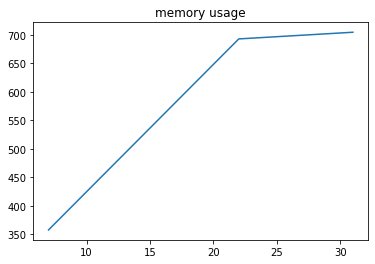

In [7]:
import matplotlib.pyplot as plt
import math
x=[7,22,31]
y=[357.8,692.7,704.4]
plt.plot(x,y)
plt.title("memory usage")
plt.show()